In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch

from img_utils import ImgUtils
from noised_image_datagen import NoisedImageDatagen
from unet import UNet

In [2]:
filenames = []
for dirpath, dirs, files in os.walk('Images/n02099601-golden_retriever'): 
  for filename in fnmatch.filter(files, '*.jpg'):
    filenames.append(os.path.join(dirpath, filename))

print(len(filenames))
train_filenames = filenames[:100]
validation_filenames = filenames[100:150]

150


In [3]:
n_timesteps = 20
datagen = NoisedImageDatagen(train_filenames, n_timesteps=n_timesteps, img_size=(64, 64))
val_datagen = NoisedImageDatagen(validation_filenames, n_timesteps=n_timesteps, img_size=(64, 64))
batch = datagen[2]
print(batch[0].shape)
print(len(datagen))

(20, 64, 64, 3)
100


In [4]:
shown_imgs_X = [ImgUtils.unscale_img(img).clip(0,1) for img in batch[0]]
shown_imgs_y = [ImgUtils.unscale_img(img).clip(0,1) for img in batch[1]]
shown_imgs_recon = [ImgUtils.unscale_img(img1 + img2).clip(0,1) for img1, img2 in zip(batch[0], batch[1])]
# uncomment to show the relation of noised_dog -> noise -> denoised_dog
# ImgUtils.show_images(list(chain.from_iterable(zip(shown_imgs_X, shown_imgs_y, shown_imgs_recon))), cols=3)

In [5]:
unet = UNet.new(img_length=64, n_downblocks=3, downscale_factor=2)
L2 = lambda hx, y: (y-hx)**2
# L1 = lambda hx, y: keras_abs(y-hx)
unet.compile(optimizer="adam", loss=L2)
unet.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-28 17:42:02.693955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 17:42:02.694196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 8)    224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 8)    584         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 8)    584         ['conv2d_1[0][0]']               
                                                                                              

In [6]:
hist = unet.fit(datagen, epochs=20, validation_data=val_datagen)

Epoch 1/20


2022-11-28 17:42:03.089150: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-28 17:42:03.551190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 99/100 [============================>.] - ETA: 0s - loss: 0.1654

2022-11-28 17:42:08.146799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 6s 48ms/step - loss: 0.1652 - val_loss: 0.1478
Epoch 2/20
100/100 [==============================] - 5s 45ms/step - loss: 0.1442 - val_loss: 0.1398
Epoch 3/20
100/100 [==============================] - 5s 46ms/step - loss: 0.1393 - val_loss: 0.1372
Epoch 4/20
100/100 [==============================] - 4s 44ms/step - loss: 0.1374 - val_loss: 0.1357
Epoch 5/20
100/100 [==============================] - 4s 44ms/step - loss: 0.1361 - val_loss: 0.1345
Epoch 6/20
100/100 [==============================] - 4s 45ms/step - loss: 0.1354 - val_loss: 0.1355
Epoch 7/20
100/100 [==============================] - 4s 44ms/step - loss: 0.1352 - val_loss: 0.1339
Epoch 8/20
100/100 [==============================] - 4s 43ms/step - loss: 0.1348 - val_loss: 0.1337
Epoch 9/20
100/100 [==============================] - 4s 44ms/step - loss: 0.1344 - val_loss: 0.1332
Epoch 10/20
100/100 [==============================] - 4s 44ms/step - loss: 0.1341 - val_loss: 0.1328


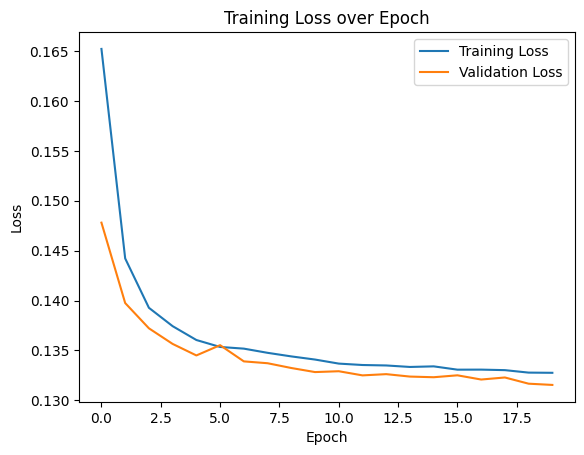

In [7]:
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epoch")
plt.show()

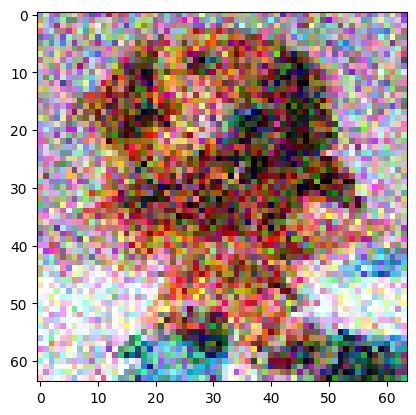

2022-11-28 17:43:34.583133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


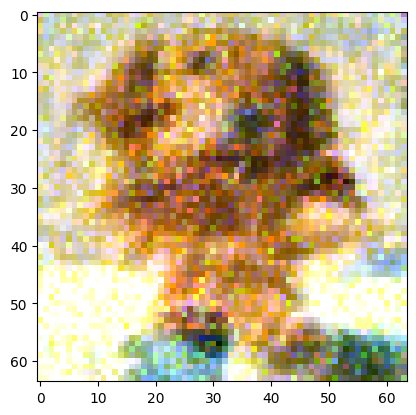

In [8]:
denoisee = batch[0][10]
plt.imshow(ImgUtils.unscale_img(denoisee).clip(0,1))
plt.show()

for i in range(n_timesteps * 5):
    noise_pred = unet.predict(np.array([denoisee]), verbose=0)[0]
    denoisee = denoisee + (1/n_timesteps) * noise_pred

plt.imshow(ImgUtils.unscale_img(denoisee).clip(0,1))
plt.show()

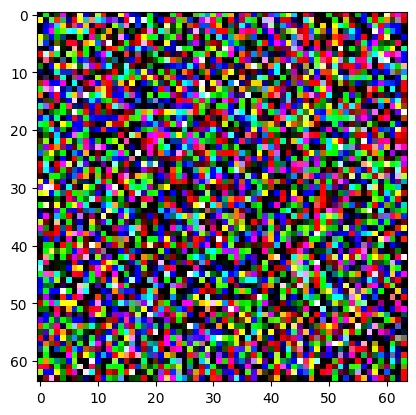

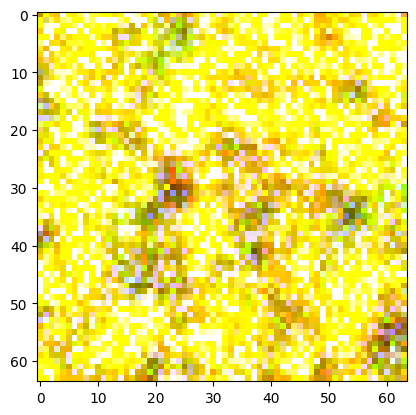

In [9]:
denoisee = (np.random.randn(64, 64, 3) * 2 - 1) 
plt.imshow(ImgUtils.unscale_img(denoisee).clip(0,1))
plt.show()

for i in range(n_timesteps*10):
    noise_pred = unet.predict(np.array([denoisee]), verbose=0)[0]
    denoisee = denoisee + (1/n_timesteps) * noise_pred


plt.imshow(ImgUtils.unscale_img(denoisee).clip(0,1))
plt.show()